<a href="https://colab.research.google.com/github/RamSaw/image-processing/blob/master/Copy_of_HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание №4

Задание присылать на обе почты почты aleksartamonov@gmail.com dashkov.alexander.om@gmail.com в виде ссылки на colab

В теме письма указать **HSE2020 HW4 <Фамилия Имя>**

soft deadline: 15.03.2020T23:59:00+0300

hard deadline: 22.03.2020T23:59:00+0300

# Поиск изображений по содержанию (30 (+20) баллов)

Вам предстоит построить систему, которая позволит выполнить поиск изображений по содержанию в базе Corel-10k, которая приложена к домашнему заданию. База состоит из 100 классов изображений по 100 изображений в каждом классе. Имя каждого изображения в базе состоит из **X.JPEG**, где X - число от 1 до 10000. Изображения из одного класса лежат подряд в промежутке 1-100, 101-200, и тд. В файле **test.dat** лежит список картинок, которые не должны участвовать в построении поисковой базы, но по которым надо будет сделать 1000 поисковых запросов. Ограничение по памяти -- 2Гб.

1. По изображениям не попавшим в **test.dat** посчитайте дескриптор с помощью алгоритма GIST.
   
2. Разбейте дескрипторы всех изображений на 100 кластеров с помощью K-Means.

3. Для каждого кластера постройте функцию хэширования (LSH), с помощью которой закодируйте каждое изображение в тренировочной выборке.

5. Релизуйте функцию `retrieve` продемонстрируйте работу `retrieve` на 5-ти случайных изображениях из **test.dat**. Замерьте время исполнения поискового запроса. Сделайте возможность вызвать `retrieve` без построения индекса, то есть приложите в решение индексированную базу, если только время построения индекса не укладывается в 1 минуту.  

5. Сделайте 1000 запросов изображениями из файла **test.dat**.  Замерьте среднее время исполнения поискового запроса в colab ноутбуке.

    
6. Для каждого запроса нужно оценить MAPk, где k=10 и посчитать среднее значение этой величины по всем запросам.

Так же за это задание можно получить еще до 20-ти дополнительных баллов. 

1. Вы можете сделать быстрый поиск. Если качество вашего поиска окажется выше, чем медиана качества по всем поисковым движкам, то вы принимаете участие в 
борьбе за 10 призовых баллов. Первое место получает 10 баллов, второе 9, третье 8 и т.д. 

2. Вы можете сделать хороший поиск. Если ваш поиск окажется быстрее, чем медиана среднего времени работы других участников, то вы принимаете участие в борьбе за точный поиск. Распределение баллов здесь будет такое же как и в конкурсе на скорость. 

Для достижения лучших результатов вам придется регулировать несколько параметров алгоритма:
- Дескриптор. Можете взять что угодно вместо GIST
- Количество кластеров k-means
- Длину кода LSH
- etc 

Принципиально нельзя использовать готовые поисковые движки. И помните о том, что время поиска очень важный параметр.

In [0]:
# installation of pyleargist
!wget http://www.fftw.org/fftw-3.3.8.tar.gz
!tar -xzvf fftw-3.3.8.tar.gz
%cd fftw-3.3.8
!./configure --enable-single --enable-shared
!make
!make install
%cd ../
!wget https://github.com/tuttieee/lear-gist-python/archive/master.zip
!unzip master.zip
%cd ./lear-gist-python-master
!wget http://lear.inrialpes.fr/src/lear_gist-1.2.tgz
!tar zxvf lear_gist-1.2.tgz
!sudo apt-get install libfftw3-3
!python setup.py build_ext
!python setup.py install

In [0]:
!pip install ml_metrics

In [1]:
from google.colab import drive
drive.mount('./gdrive')

Mounted at ./gdrive


In [0]:
DRIVE_DATA_ROOT = './gdrive/My Drive/cv2_data'

In [0]:
import gist
import numpy as np
import cv2
from sklearn.cluster import KMeans
import random
import os
import torch
import matplotlib.pylab as plt
%matplotlib inline
import time
from datetime import timedelta
from mpl_toolkits.axes_grid1 import ImageGrid
import ml_metrics as metrics

In [4]:
def make_reproducible(seed, make_cuda_reproducible):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if make_cuda_reproducible:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

SEED = 2341
make_reproducible(SEED, False)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cpu


In [0]:
RESIZE=(64, 64)
GIST_PARAMS = {'nblocks': 4, 'orientations_per_scale': [8, 8, 8, 8]}
N_CLUSTERS = 100
LSH_RANDOM_VECTORS_NUM = 10
LSH_BUCKETS_NUM = 3
N_RETRIEVE_SHOW = 10
N_RETRIEVE_MEASURE_TIME = 10
N_RETRIEVE_MAPK = 10

In [0]:
def configure_gist_descriptor(gist_params):
    def gist_descriptor(img):
        return gist.extract(img, gist_params['nblocks'], gist_params['orientations_per_scale'])
    return gist_descriptor

In [0]:
def test_gist():
  img = (np.random.rand(126, 187, 3) * 255).astype('uint8')
  gist_descriptor = configure_gist_descriptor(GIST_PARAMS)
  print(img.shape)
  img_gist = gist_descriptor(img)
  print(img_gist.shape)
  print(img_gist[:5])

In [65]:
test_gist()

(126, 187, 3)
(1536,)
[0.226085   0.22149731 0.21737954 0.21908814 0.22682065]


In [0]:
def get_test_image_names():
    with open(DRIVE_DATA_ROOT + '/test.dat', 'r') as f:
        return [l.strip() for l in f]

In [0]:
TEST_IMAGE_NAMES = get_test_image_names()

In [68]:
print(TEST_IMAGE_NAMES[:5])
print(len(TEST_IMAGE_NAMES))

['8.JPEG', '11.JPEG', '17.JPEG', '31.JPEG', '37.JPEG']
1000


In [0]:
def get_class_from_filepath(filepath):
  return int(filepath.split('/')[-1].split('_')[0])

def get_image_name_from_filepath(filepath):
  return filepath.split('/')[-1].split('_')[-1].split('.')[0] + '.JPEG'

def load_data(resize=None):
  import zipfile
  from tqdm.auto import tqdm

  train_X = []
  test_X = []
  train_Y = []
  test_Y = []
  print('Loading data...')
  with zipfile.ZipFile(DRIVE_DATA_ROOT + '/Corel.zip', 'r') as zip_file:
    for filepath in tqdm(zip_file.namelist()):
        if filepath.endswith('.jpg'):
          data = zip_file.read(filepath)
          img = cv2.imdecode(np.frombuffer(data, np.uint8), cv2.IMREAD_COLOR) 
          img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
          if resize is not None:
            img = cv2.resize(img, resize)
          cls = get_class_from_filepath(filepath)
          filename = get_image_name_from_filepath(filepath)
          if filename in TEST_IMAGE_NAMES:
            test_X.append(img)
            test_Y.append(cls)
          else:
            train_X.append(img)
            train_Y.append(cls)
  return np.array(train_X), np.array(test_X), np.array(train_Y), np.array(test_Y)

In [70]:
TRAIN_X, TEST_X, TRAIN_Y, TEST_Y = load_data(resize=RESIZE)

Loading data...


In [71]:
print('TRAIN')
print(TRAIN_X.shape)
print(TRAIN_Y.shape)
print(TRAIN_Y[905:910])
print(TRAIN_X[900].shape)
print('TEST')
print(TEST_X.shape)
print(TEST_Y.shape)
print(TEST_Y[905:910])
print(TEST_X[900].shape)

TRAIN
(9000, 64, 64, 3)
(9000,)
[19 19 19 19 19]
(64, 64, 3)
TEST
(1000, 64, 64, 3)
(1000,)
[91 91 91 91 91]
(64, 64, 3)


In [0]:
GIST_DESCRIPTOR = configure_gist_descriptor(GIST_PARAMS)

In [0]:
def apply_descriptor(images, descriptor):
  from tqdm.auto import tqdm
  print('Applying discriptor to images...')
  descripted_example = descriptor(images[0])
  result = np.empty((len(images), descripted_example.shape[0]), dtype=descripted_example.dtype)
  for i in tqdm(range(len(images))):
    result[i] = descriptor(images[i])
  return result

In [74]:
GIST_TRAIN_X = apply_descriptor(TRAIN_X, GIST_DESCRIPTOR)

Applying discriptor to images...


In [75]:
print(GIST_TRAIN_X.shape)
print(GIST_TRAIN_X[:3])

(9000, 1536)
[[0.17731032 0.12308536 0.13594766 ... 0.02359865 0.02016309 0.04214559]
 [0.18019432 0.13076448 0.18681873 ... 0.03263002 0.02861013 0.03372616]
 [0.08656653 0.04692985 0.12423269 ... 0.0030128  0.00678639 0.01008673]]


In [0]:
KMEANS = KMeans(n_clusters=N_CLUSTERS, random_state=SEED).fit(GIST_TRAIN_X)

In [77]:
KMEANS.cluster_centers_

array([[0.101259  , 0.09085262, 0.07564885, ..., 0.0314953 , 0.02974537,
        0.01847387],
       [0.07528119, 0.08696933, 0.08911383, ..., 0.03239984, 0.03487488,
        0.02709045],
       [0.09203939, 0.09890266, 0.10167183, ..., 0.01933443, 0.0204443 ,
        0.0176545 ],
       ...,
       [0.14160472, 0.16481933, 0.15753472, ..., 0.04307164, 0.04203994,
        0.03247723],
       [0.03742083, 0.04828626, 0.07251215, ..., 0.0286362 , 0.03682266,
        0.02560044],
       [0.3205822 , 0.27158242, 0.26124734, ..., 0.07121045, 0.05951137,
        0.0572198 ]], dtype=float32)

In [0]:
def get_dict_based_on_clusters(kmeans, data):
  d = dict()
  for i, label in enumerate(kmeans.labels_):
    if label not in d:
      d[label] = {'indices': [], 'data': []}
    d[label]['data'].append(data[i])
    d[label]['indices'].append(i)
  for label in d:
    d[label]['data'] = np.array(d[label]['data'])
    d[label]['indices'] = np.array(d[label]['indices'])
  return d

In [0]:
CLUSTERED_GIST_TRAIN_X = get_dict_based_on_clusters(KMEANS, GIST_TRAIN_X)

In [99]:
print(sorted(CLUSTERED_GIST_TRAIN_X.keys()))
print(len(CLUSTERED_GIST_TRAIN_X))
print(CLUSTERED_GIST_TRAIN_X[0]['data'].shape)
print(CLUSTERED_GIST_TRAIN_X[0]['indices'].shape)
print(CLUSTERED_GIST_TRAIN_X[0]['indices'][:5])
print(CLUSTERED_GIST_TRAIN_X[99]['data'].shape)
print(CLUSTERED_GIST_TRAIN_X[99]['indices'].shape)
print(CLUSTERED_GIST_TRAIN_X[99]['indices'][:5])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
100
(135, 1536)
(135,)
[ 142  143  488  687 1057]
(4, 1536)
(4,)
[3922 5672 5739 8550]


In [0]:
def apply_lsh_to_each_cluster(clustered_data, num_of_random_vectors):
  d = dict()
  for label, cluster_dict in clustered_data.items():
    cluster_data = cluster_dict['data']
    indices = cluster_dict['indices']
    lsh_model = LSH(cluster_data)
    lsh_model.train(num_of_random_vectors)
    d[label] = {'indices': indices, 'lsh_model': lsh_model}
  return d

In [0]:
LSH_GIST_TRAIN_X = apply_lsh_to_each_cluster(CLUSTERED_GIST_TRAIN_X, num_of_random_vectors=LSH_RANDOM_VECTORS_NUM)

In [102]:
print(sorted(LSH_GIST_TRAIN_X.keys()))
print(len(LSH_GIST_TRAIN_X))
print(LSH_GIST_TRAIN_X[0])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
100
{'indices': array([ 142,  143,  488,  687, 1057, 1199, 1492, 1509, 1637, 1710, 1711,
       1712, 1713, 1714, 1715, 1716, 1717, 1718, 1719, 1720, 1721, 1722,
       1723, 1724, 1725, 1726, 1727, 1728, 1729, 1734, 1742, 1743, 1745,
       1746, 1752, 1753, 1755, 1756, 1758, 1761, 1762, 1763, 1764, 1765,
       1766, 1767, 1768, 1771, 1772, 1776, 1778, 1779, 1780, 1782, 1786,
       1788, 1797, 1894, 2007, 2013, 2047, 2384, 2510, 2613, 2619, 2622,
       2640, 2655, 2772, 2784, 3008, 3009, 3056, 3075, 3576, 3588, 3590,
       4026, 4072, 4080, 4090, 4093, 4097, 4098, 4105, 4106, 4119, 4233,
       48

In [0]:
def add_cluster_centers(kmeans, d):
  new_d = dict()
  new_d['kmeans'] = kmeans
  new_d['clusters'] = d
  return new_d

In [0]:
def create_index(descriptor_params, kmeans, lsh_data):
  index = add_cluster_centers(kmeans, lsh_data)
  index['descriptor_params'] = descriptor_params
  return index

In [0]:
INDEX = create_index(GIST_PARAMS, KMEANS, LSH_GIST_TRAIN_X)

In [0]:
def save_index(index):
  import pickle
  with open(DRIVE_DATA_ROOT + '/index.pkl', 'wb') as f:
    pickle.dump(index, f)
  return

def load_index():
  import pickle
  with open(DRIVE_DATA_ROOT + '/index.pkl', 'rb') as f:
    return pickle.load(f)

In [0]:
save_index(INDEX)

In [0]:
def get_index_size_in_gb():
  return os.path.getsize(DRIVE_DATA_ROOT + '/index.pkl') / (1024*1024*1024)

In [109]:
get_index_size_in_gb()

0.06381311174482107

In [0]:
def retrieve(sample, n, buckets_num=LSH_BUCKETS_NUM, index=None):
  def retrieve_image_idx_from_lsh(lsh_model, indices):
    retrieved = lsh_model.query(sample, n, buckets_num)
    image_indices = np.array([indices[idx] for idx in retrieved['id'].keys()])
    return image_indices

  if index is None:
    index = load_index()
  descriptor = configure_gist_descriptor(index['descriptor_params'])
  sample = descriptor(sample)
  label = index['kmeans'].predict(sample.reshape(1, -1))
  lsh_dict = index['clusters'][int(label)]
  images_idx = retrieve_image_idx_from_lsh(lsh_dict['lsh_model'], lsh_dict['indices'])
  return images_idx

In [0]:
def show_retrieve():
  index = load_index()
  samples_indices = random.sample([i for i in range(len(TEST_X))], k=5)
  samples = TEST_X[samples_indices]
  for i, sample in enumerate(samples):
    print(f'{i + 1} query')
    start = time.time()
    images_idx = retrieve(sample, n=N_RETRIEVE_SHOW, index=index)
    end = time.time()
    print(f'Duration: {end - start}')
    images = TRAIN_X[images_idx]
    plt.imshow(sample)
    fig = plt.figure(figsize=(10., 10.))
    grid = ImageGrid(fig, 111, nrows_ncols=(1, N_RETRIEVE_SHOW), axes_pad=0.1)
    for ax, im in zip(grid, images):
        ax.imshow(im)
    plt.show()
    print()
    print()

1 query
Duration: 0.03408551216125488


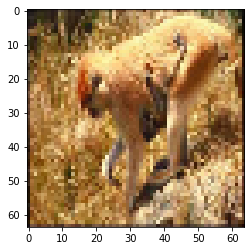

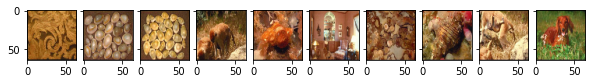



2 query
Duration: 0.04914259910583496


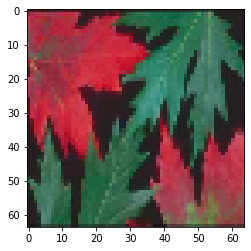

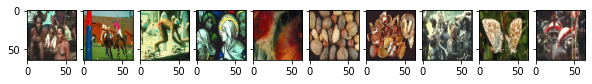



3 query
Duration: 0.044286251068115234


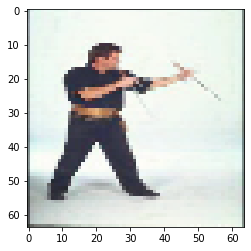

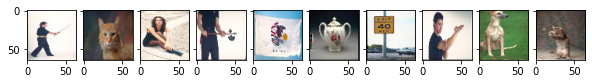



4 query
Duration: 0.044534921646118164


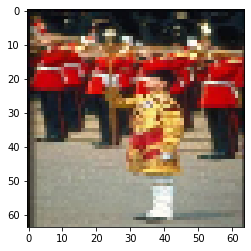

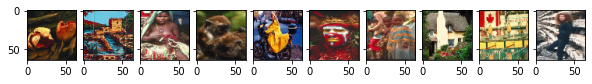



5 query
Duration: 0.04512381553649902


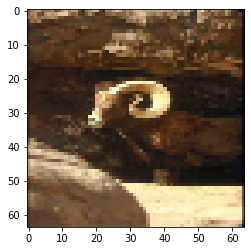

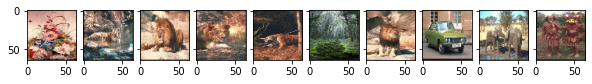

In [115]:
show_retrieve()

In [0]:
def measure_time_on_test(n=None):
  from tqdm.auto import tqdm
  index = load_index()
  durations = []
  if n is not None:
    samples_indices = random.sample([i for i in range(len(TEST_X))], k=n)
    samples = TEST_X[samples_indices]
  else:
    samples = TEST_X
  for sample in tqdm(samples):
    start = time.time()
    retrieve(sample, n=N_RETRIEVE_MEASURE_TIME, index=index)
    end = time.time()
    elapsed = end - start
    durations.append(elapsed)
  print(f'Mean query time: {np.mean(durations)}')
  print(f'Std query time: {np.std(durations)}')

In [117]:
measure_time_on_test()


Mean query time: 0.04079838275909424
Std query time: 0.002460565328074987


In [0]:
def get_ground_truth_by_class():
  d = dict()
  for i in range(len(TRAIN_X)):
    label = TRAIN_Y[i]
    if label not in d:
      d[label] = []
    d[label].append(i)
  return d

def calculate_mapk(n=None):
  from tqdm.auto import tqdm
  index = load_index()
  ground_truth_by_class = get_ground_truth_by_class()
  actual_all = []
  predicted_all = []
  for sample in tqdm(list(zip(TEST_X, TEST_Y))[:n]):
    img, label = sample
    actual = ground_truth_by_class[label]
    n_to_retrieve = len(actual) if N_RETRIEVE_MAPK is None else N_RETRIEVE_MAPK
    predicted = retrieve(img, n=n_to_retrieve, index=index)
    actual_all.append(actual)
    predicted_all.append(predicted)
  mapk = metrics.mapk(actual_all, predicted_all, k=10)
  return mapk

In [114]:
calculate_mapk()

0.20934579365079364

In [0]:
from copy import copy
from itertools import combinations
import numpy as np
from pandas import DataFrame
from sklearn.metrics.pairwise import pairwise_distances


class LSH:
    def __init__(self, data):
        self.data = data
        self.model = None

    def __generate_random_vectors(self, num_vector, dim):
        return np.random.randn(dim, num_vector)

    def train(self, num_vector, seed=None):
        dim = self.data.shape[1]
        if seed is not None:
            np.random.seed(seed)

        random_vectors = self.__generate_random_vectors(num_vector, dim)
        powers_of_two = 1 << np.arange(num_vector - 1, -1, -1)

        table = {}

        # Partition data points into bins
        bin_index_bits = (self.data.dot(random_vectors) >= 0)

        # Encode bin index bits into integers
        bin_indices = bin_index_bits.dot(powers_of_two)

        # Update `table` so that `table[i]` is the list of document ids with bin index equal to i.
        for data_index, bin_index in enumerate(bin_indices):
            if bin_index not in table:
                # If no list yet exists for this bin, assign the bin an empty list.
                table[bin_index] = []
            # Fetch the list of document ids associated with the bin and add the document id to the end.
            table[bin_index].append(data_index)

        self.model = {'bin_indices': bin_indices, 'table': table,
                      'random_vectors': random_vectors, 'num_vector': num_vector}
        return self

    def __search_nearby_bins(self, query_bin_bits, table, search_radius=2, initial_candidates=set()):
        num_vector = self.model['num_vector']
        powers_of_two = 1 << np.arange(num_vector - 1, -1, -1)

        # Allow the user to provide an initial set of candidates.
        candidate_set = copy(initial_candidates)

        for different_bits in combinations(range(num_vector), search_radius):
            alternate_bits = copy(query_bin_bits)
            for i in different_bits:
                alternate_bits[i] = 1 if alternate_bits[i] == 0 else 0

            # Convert the new bit vector to an integer index
            nearby_bin = alternate_bits.dot(powers_of_two)

            # Fetch the list of documents belonging to the bin indexed by the new bit vector.
            # Then add those documents to candidate_set
            if nearby_bin in table:
                candidate_set.update(table[nearby_bin])

        return candidate_set

    def query(self, query_vec, k, max_search_radius, initial_candidates=set()):

        if not self.model:
            print('Model not yet build. Exiting!')
            exit(-1)

        data = self.data
        table = self.model['table']
        random_vectors = self.model['random_vectors']

        bin_index_bits = (query_vec.dot(random_vectors) >= 0).flatten()

        candidate_set = set()
        # Search nearby bins and collect candidates
        for search_radius in range(max_search_radius + 1):
            candidate_set = candidate_set.union(self.__search_nearby_bins(bin_index_bits, table,
                                                      search_radius, initial_candidates=initial_candidates))
        # Sort candidates by their true distances from the query
        nearest_neighbors = DataFrame({'id': list(candidate_set)})
        candidates = data[np.array(list(candidate_set)), :]
        nearest_neighbors['distance'] = pairwise_distances(candidates, query_vec.reshape(1, -1), metric='cosine').flatten()

        return nearest_neighbors.nsmallest(k, 'distance')

# Сегментация изображений (20 баллов)

Решите задачу сегментации изображений для набора http://www.vision.caltech.edu/Image_Datasets/leaves/leaves.tar Результатом сегментации каждого изображения должно быть изображение с разметкой листа выделенного на черном фоне. Оценка работы алгоритма будет производится по аккуратности выделения сегментов, которые соответствуют листьям. Выделение листьев будет оцениваться по F-мере, вычисленной попиксельно относительно ручной разметки сегментов. В качестве результата выполнения задания помимо исходного кода необходимо прислать полученные результаты сегментации для всех изображений коллекции. (положить их в отдельную папку не изменяя имя файлов leaves/*.jpg > result/*.jpg)